# <font color='blue'> Sec 6: Chain-of-Thought and ReACT Prompting </font>

#### <font color='red'> Content: Demand‑Spike Detective </font>
In this hands-on exercise, you will <font color='red'>  **guide an LLM to explain an unexpected sales spike**. </font>

## A. Chain-of-Thoughts

### Outline:

    A.1 Setup
    A.2 Understand sales data, promotional calendars, etc. 
    A.3 Craft a Simple CoT prompt
    A.4 Craft a More Developed CoT Prompt

## A.1 Setup

In [2]:
from openai import OpenAI
from IPython.display import Markdown, display
import os
import pandas as pd

import json
import re

with open('api_key.json', 'r') as file:
    api_keys = json.load(file)
    openai_key = api_keys["openai"]

# print(openai_key)
client = OpenAI(api_key=openai_key)

from utils import (
    display_responses,
    get_completion,
    MODEL,
)
from utils_cot_react import (
    # Synthetic data
    get_competitor_pricing_data,
    get_promotions_data,
    get_sales_data,
    get_weather_data,
)

## A.2 Understand sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [3]:
# View the data
get_sales_data()[:3]

[{'date': datetime.date(2024, 1, 10),
  'product_id': 'P001',
  'product_name': 'Product 1',
  'quantity': 255,
  'revenue': 15547.35},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P002',
  'product_name': 'Product 2',
  'quantity': 65,
  'revenue': 2297.1},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P003',
  'product_name': 'Product 3',
  'quantity': 90,
  'revenue': 7301.7}]

In [4]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [5]:
# Show the sales data

sales_df = sales_df.sort_values(by=["product_id", "date"]).reset_index(drop=True)
sales_df

,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
1,2024-01-11,P001,Product 1,235,14327.95
2,2024-01-12,P001,Product 1,310,18900.70
3,2024-01-13,P001,Product 1,302,18412.94
4,2024-01-14,P001,Product 1,305,18595.85
5,2024-01-15,P001,Product 1,301,18351.97
6,2024-01-16,P001,Product 1,226,13779.22
7,2024-01-10,P002,Product 2,65,2297.10
8,2024-01-11,P002,Product 2,86,3039.24
9,2024-01-12,P002,Product 2,80,2827.20


In [6]:
promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [7]:
weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [8]:
# Show the competitor pricing data
competitor_pricing_df

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04
5,Product 1,2024-01-15,60.97,{},68.52,59.63,73.03
6,Product 1,2024-01-16,60.97,"{'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}",44.69,57.69,70.51
7,Product 2,2024-01-10,35.34,{},34.57,42.01,42.02
8,Product 2,2024-01-11,35.34,"{'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}",37.91,29.29,22.85
9,Product 2,2024-01-12,35.34,{},41.81,33.35,29.62


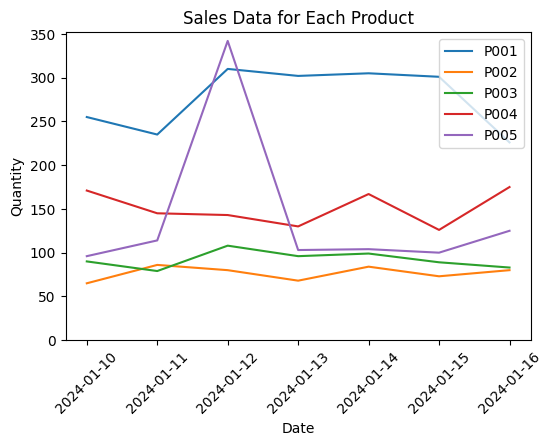

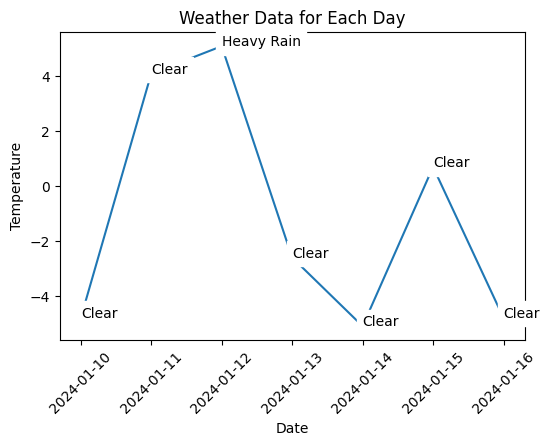

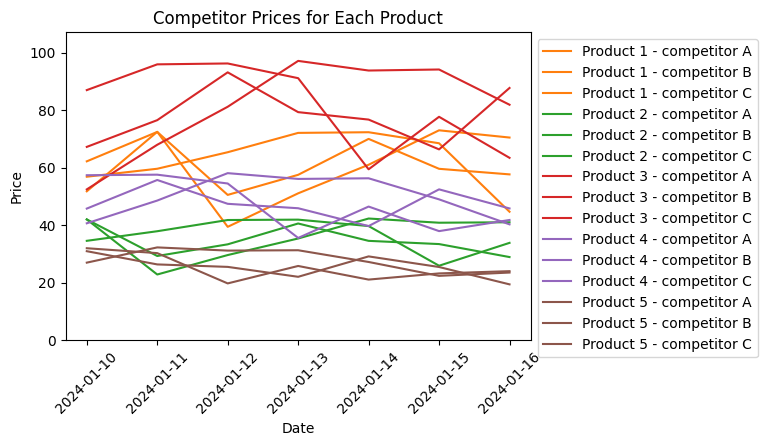

In [9]:
# Graph the sales data

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.ylim(0, sales_df["quantity"].max() + 10)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for product in competitor_pricing_df["product"].unique():
    for competitor in ["a", "b", "c"]:
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.ylim(0, competitor_pricing_df.filter(like="price").max().max() + 10)
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

Reflection:

* Sales spike for Product 5 on January 12th
* The "Weekend Special" promotion which started on January 12th, but that was for Product 2. Still, it may have had an indirect effect on Product 5.
* Weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.
* As for Competitor pricing, we see that Product 5's price for one competitor dropped on January 12th, which may have led to more overall consumer interest in that product or may have coincided with an ad campaign.

In practice, a human would look at all these factors and more to determine the cause of the sales spike by digging deeper.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and provide some reasons similar to what we've observed as human beings.

## A.3 Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.

<div style="color: red">Note: Many modern LLMs may not need an explicit "think in steps" phrase in order to think in steps before providing an answer, as this behavior can be included in training process. Consider running your prompts with and without asking for CoT explicitly. In fact, multiple runs may yield different results, so it's worth simply re-running the same prompts more than once.</div>


In [10]:

system_prompt_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step
"""

# NOTE, explicit_cot prompt has statement 'Think step by step'

system_prompt_no_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""

user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
explicit_cot_response_1 = get_completion(
    client, 
    system_prompt=system_prompt_explicit_cot, 
    user_prompt=user_prompt_analyze,
)
no_explicit_cot_response_2 = get_completion(
    client, 
    system_prompt=system_prompt_no_explicit_cot, 
    user_prompt=user_prompt_analyze,
)
print("Response received!\n")

# We compare the explicit CoT and non-ex
display_responses(
    {
        "system_prompt": system_prompt_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": explicit_cot_response_1,
    },
    {
        "system_prompt": system_prompt_no_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": no_explicit_cot_response_2,
    },
)

Sending prompt to gpt-4.1-nano model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th></tr><tr><td>Response:<br />Let's analyze the data systematically to identify potential causes for sales spikes.

---

### 1. **Sales Data Overview & Key Observations**

- **Dates with notable sales increases:**
  - **January 12, 2024**
  - **January 16, 2024**

- **Products with significant sales spikes:**
  - **Product 1 (P001)**
  - **Product 2 (P002)**
  - **Product 3 (P003)**
  - **Product 4 (P004)**
  - **Product 5 (P005)**

---

### 2. **Correlation with Promotion Schedule**

**Promotions during the period:**
- **Weekend Special (Jan 12-14):** 10% off on **P002**
- **Flash Sale (Jan 15-16):** 15% off on **P001, P003, P005**

**Key points:**
- **January 12:** Promotion "Weekend Special" on P002 is active.
- **January 15-16:** "Flash Sale" on P001, P003, P005.

---

### 3. **Analysis of Sales Spikes by Date**

#### **January 12, 2024**
- **Significant increases** observed in:
  - P001: 310 units (highest so far)
  - P002: 80 units
  - P003: 108 units
  - P004: 143 units
  - P005: 342 units (peak for P005)

**Relation to Promotions:**
- **P002**: Under "Weekend Special" (10% off). The sale price for P002 is around **$35.34**, with competitors offering prices mostly higher or similar, and some with discounts.
- **P001**: No direct promotion on Jan 12, but its sales are high.
- **P003 & P005**: No promotion on Jan 12, but their sales are high on this date.

**Weather impact:**
- Heavy rain and flood warning may have influenced purchasing behavior (possibly increased demand for certain products).

**Competitor pricing:**
- For P001, competitor prices fluctuated but remained mostly above our price, possibly incentivizing purchases.
- For P005, a competitor A sale at $19.75 (vs. our $26.95) might have driven demand.

---

#### **January 16, 2024**
- **Highest sales quantities:**
  - P001: 226 units
  - P002: 80 units
  - P003: 83 units
  - P004: 175 units
  - P005: 125 units

**Promotion:**
- "Flash Sale" on Jan 15-16, offering 15% off on P001, P003, P005.

**Price comparison:**
- P001: Our price remains at $60.97; competitor A's sale at $44.69 (17% discount) likely attracted customers.
- P003 & P005: Similar discounts with competitor sale prices significantly lower than ours.

**Weather Conditions:**
- Clear weather on Jan 16 might have increased foot traffic or online activity.

---

### 4. **Other Influencing Factors**

- **Pricing Strategy:**
  - On promotional days, our prices remained static, but competitors often offered deeper discounts, leading to increased sales.
  - The presence of targeted promotions (Weekend Special, Flash Sale) aligns with sales peaks.

- **Weather Conditions:**
  - Heavy rain and flood warnings around Jan 12 could have **either suppressed or increased demand** depending on the products (e.g., emergency supplies, indoor items).

- **Competitor Promotions:**
  - Notably, on Jan 16, competitor A had a sale reducing their price on P001 from ~$72 to ~$44, which likely contributed to the spike in sales.

---

### 5. **Hypotheses for Sales Spikes**

| Date | Product(s) | Likely Cause(s) | Supporting Evidence |
|---------|--------------|-------------------|---------------------|
| **January 12** | P001, P002, P003, P004, P005 | - The "Weekend Special" promotion on P002<br>- Possibly weather-driven demand (heavy rain, flood warnings)<br>- Competitive pricing advantage | - Promotion on P002<br>- Highest recorded sales for P005<br>- Heavy rain may have increased demand for indoor or emergency products, or alternatively suppressed outdoor shopping |
| **January 16** | P001, P002, P003, P004, P005 | - The "Flash Sale" promotion (15% off) on P001, P003, P005<br>- Competitor A's significant price discount on P001<br>- Clear weather leading to higher shopping activity | - Promotional discounts making products more attractive<br>- Competitor pricing strategies influencing consumer choice<br>- Peak sales coinciding with promotional days and favorable weather |

---

### 6. **Additional Considerations**
- **Product-specific dynamics:**
  - P005 saw an extraordinary spike on Jan 12 (342 units); likely driven by its own demand spike and possibly influenced by weather or other external factors.
  - P001 and P003 benefited from the "Flash Sale" (Jan 15-16), with increased sales correlating with discount periods.

- **Market Competition:**
  - When competitors offer significant discounts, our sales tend to increase if our prices remain competitive or if customers perceive added value during promotions.

- **Weather Impact:**
  - Adverse weather (heavy rain, floods) could either suppress or stimulate demand depending on product category.

---

### **Summary of Hypotheses:**

- **Promotion schedules** are primary drivers of sales spikes on Jan 12 and Jan 16, especially noticeable for products under active promotional discounts.
- **Competitor pricing strategies**, particularly deep discounts, likely amplified the effect of our promotional efforts, especially on Jan 16.
- **Weather conditions** may have influenced consumer behavior, with heavy rain possibly increasing demand for certain products or suppressing outdoor shopping.
- **Product-specific demand patterns** suggest that both promotional activity and external factors (like weather and competitor actions) significantly impact sales volumes.

---

**Final note:** To refine these hypotheses, further data on product categories, consumer behavior, and specific promotional messaging would be beneficial.</td><td>Response:<br />Based on the provided data, several factors contribute to the observed sales spikes, particularly around January 12-16, 2024. Here's a detailed analysis:

---

### 1. **Sales Trends & Key Spikes**
- **Product 1 (P001):**  
  - Significant increase in daily sales quantity, peaking at **310 units on 2024-01-12**.
  - Revenue also peaks on this date (~$18,900), indicating a strong sales event.

- **Product 2 (P002):**  
  - Noticeable sales increase on 2024-01-12 (86 units), with a slight dip afterward.
  
- **Product 3 (P003):**  
  - Highest sales volume on 2024-01-12 (108 units), with a consistent rise leading to this peak.
  
- **Product 4 (P004):**  
  - Sales rise on 2024-01-12 (143 units) and 2024-01-14 (167 units).
  
- **Product 5 (P005):**  
  - Sharp increase on 2024-01-12 (342 units), the highest in the dataset.

---

### 2. **Correlation with Promotions**
- **Promotion Periods:**
  - **Weekend Special (Jan 12-14):** 10% off on **P002**.
  - **Flash Sale (Jan 15-16):** 15% off on **P001, P003, P005**.

**Impact Analysis:**
- The **peak sales on Jan 12** coincide precisely with the **Weekend Special** promotion for Product 2, likely driving the jump.
- The **continued high sales on Jan 14-16** coincide with the **Flash Sale**, which applies to P001, P003, and P005.  
- The **highest sales for P005 (Jan 12)** suggests the promotion's strong influence.

### 3. **Pricing & Competitor Data**
- **Product 1 (P001):**  
  - Price remained stable at ~$60.97.
  - On Jan 12, competitors offered **significantly lower prices** (e.g., C39.44, B50.55), but **our price** remained higher.
  - Despite higher pricing, sales spiked during the promotional period, indicating the **promotion (discount)** was effective in attracting buyers, possibly overriding price sensitivity.

- **Product 2 (P002):**  
  - Price stable at ~$35.34.
  - During Jan 12, competitors had **sale prices as low as ~$22.85 (C)**, which likely boosted sales during the Weekend Special.

- **Product 3 (P003):**  
  - Price stable at ~$81.13.
  - Competitors offered discounts (e.g., C52.47, B67.26 on Jan 12), aligning with increased sales during Jan 12-16, especially with the **Flash Sale**.

- **Product 4 (P004):**  
  - Price stable at ~$48.52.
  - Competitors' prices varied but generally remained higher or comparable.
  - Sales increases align with the promotion period, suggesting the discount helped drive volume.

- **Product 5 (P005):**  
  - Price stable at ~$26.95.
  - During Jan 12-16, competitors offered discounts (~$19.75 sale price on Jan 12), contributing to higher sales.

---

### 4. **Weather & External Factors**
- **Heavy Rain and Flood Warning (Jan 12):**  
  - Typically, bad weather can suppress demand; however, the data shows a spike in sales.  
  - This suggests the promotions and discounts had a stronger influence than weather conditions, or possibly consumers stocked up in anticipation of poor weather.

- **High Winds (Jan 15):**  
  - No negative impact observed on sales, consistent with the trend that promotional discounts outweighed weather effects.

### 5. **Summary of Causes for Sales Spikes**
- **Promotion Effects:**
  - The **Weekend Special** (Jan 12-14) on P002 triggered increased sales, especially for that SKU.
  - The **Flash Sale** (Jan 15-16) on P001, P003, and P005 further amplified sales volume.
- **Competitive Pricing:**
  - For some SKUs, lower competitor prices during promotional periods increased demand.
  - For P001, despite higher prices, the promotional discount likely incentivized purchases.
- **Consumer Behavior:**
  - Consumers tend to respond positively to discounts and promotional deals, particularly during limited-time offers.
- **Weather Influence:**
  - While adverse weather typically hinders demand, in this case, promotions seem to have mitigated weather effects or even encouraged stockpiling.

---

### **Conclusion**
The primary drivers of the sales spikes between Jan 12-16, 2024, are **timely promotions** aligned with consumer buying cycles and competitive pricing strategies. Although weather conditions were unfavorable (heavy rain, flood warning), the promotions appear to have been sufficiently compelling to sustain or boost demand.

---

**Recommendations for Future Analysis:**
- Monitor the impact of specific promotional messaging.
- Correlate sales with real-time competitor price changes.
- Investigate consumer sentiment or foot traffic data during these periods for a more comprehensive view.</td></tr></table>

## A.4 Craft a More Developed CoT Prompt

Let's add more to our CoT prompt. Let's ask the model to follow a specific set of steps in an **instructions section**. This may help us not only get final answers that align with our needs, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to identify the single largest spike and hypothesize its causes, using the following output format:

````

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}
```

````

In [11]:
# Let's add some more components to our CoT Prompt

system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think in steps.
"""

user_prompt_analyze = f"""
## INSTRUCTIONS:

Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
- Find all sale spikes for all products
- For each product:
    * Dates of sale apikes
    * Amount of the sale spikes and percentage increase
    * Possible reasons of sale spikes according to provided:
        - sale data
        - promotion schedule
        - weather conditions
        - competitor pricing data
- Start with your analysis
- Conclude the largest spike with percentage and a short explanation of it.

--

## OUTPUT FORMAT:

STRUCTURED ANALYSIS:
[structured analysis]

LARGEST SPIKES:
```json
{{
    "date": yyyy-mm-dd,
    "sales before spike": "x.xx",
    "sales after spike": "x.xx",
    "increase percent": "x.xx %",
    "casue of spikes": [
        "reason-1",
        "reason-2",
        "reason-3",
    ]
    
}}
```

---

## CONTEXT

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(client, 
                              system_prompt=system_prompt_cot, 
                              user_prompt=user_prompt_analyze,
                              model=MODEL)
print("Response received!\n")

Sending prompt to gpt-4.1-nano model...
Response received!



In [12]:
def parse_analysis_and_largest_spike(response):
    if "```json" not in response:
        print()
        print(response)
        raise RuntimeError(
            " No LARGEST SPIKE found in response. Looking for: \n\n```json"
        )

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)
display(Markdown(analysis))

# STRUCTURED ANALYSIS:

## Overview:
The data shows daily sales quantities for five products over a week, with some notable variations. Promotions are scheduled from January 12 to 16, covering two promotional campaigns: "Weekend Special" (Jan 12-14) for P002, and "Flash Sale" (Jan 15-16) for P001, P003, and P005. Weather data indicates generally clear conditions, with a heavy rain on Jan 12 and high winds on Jan 15. Competitor pricing varies daily, with some discounts and sales.

---

## Product-wise analysis:

### Product 1 (P001):
- **Sales data:**
  - Jan 10: 255 units
  - Jan 11: 235 units
  - Jan 12: 310 units  (**Biggest spike**)
  - Jan 13: 302 units
  - Jan 14: 305 units
  - Jan 15: 301 units
  - Jan 16: 226 units

- **Observation:**
  - Sharp increase on Jan 12 (from 235 to 310 units, approx. 31.5% increase from Jan 11).
  - Slight decline after Jan 12, but still high.
  
- **Promotion influence:**
  - "Flash Sale" started on Jan 15-16, so no effect yet on Jan 12.
  
- **Pricing & competitor data:**
  - The price remained at 60.97.
  - On Jan 12, the competitor B dropped their price significantly (from ~69.24 to 50.55, a 27% discount), and C also reduced their price (~49.92 to 39.44).
  
- **Possible reason for Jan 12 spike:**
  - Competitor B's sale (27% discount) likely motivated customers to buy more.
  - No promotion scheduled yet; the spike correlates strongly with competitor discounting.

---

### Product 2 (P002):
- **Sales data:**
  - Jan 10: 65 units
  - Jan 11: 86 units
  - Jan 12: 80 units
  - Jan 13: 68 units
  - Jan 14: 84 units
  - Jan 15: 73 units
  - Jan 16: 80 units

- **Observation:**
  - Moderate fluctuations, no clear spike.
  - Slight increase on Jan 11 and Jan 14.
  
- **Promotion influence:**
  - "Weekend Special" (Jan 12-14) for P002.
  - On Jan 12, sales are 80 units, slightly lower than Jan 11.
  - On Jan 14, sales are 84, a small increase.
  
- **Pricing & competitor data:**
  - Our price remains at 35.34.
  - Competitors reduced their prices on Jan 12 (~40.13 to 29.29), which likely contributed to increased sales during the promotion.
  
- **Possible reasons for Jan 12 & 14 sales:**
  - The promotion and the competitor discounts likely drove the sales, though no dramatic spike.

---

### Product 3 (P003):
- **Sales data:**
  - Jan 10: 90 units
  - Jan 11: 79 units
  - Jan 12: 108 units (**biggest spike**)
  - Jan 13: 96 units
  - Jan 14: 99 units
  - Jan 15: 89 units
  - Jan 16: 83 units

- **Observation:**
  - Notable increase on Jan 12 (from 79 to 108 units, about 36.7% increase from Jan 11).
  
- **Promotion influence:**
  - "Flash Sale" from Jan 15-16, so not yet active during Jan 12.
  
- **Pricing & competitor data:**
  - Our price steady at 81.13.
  - Competitor B and C discounts on Jan 12 (~92.14 to 67.26 and 66.42 to 52.47 respectively).
  
- **Possible reason for Jan 12 spike:**
  - Competitor discounts (up to 27%) likely triggered increased purchasing.
  - No active promotion yet; the spike is probably driven by competitor pricing strategies.

---

### Product 4 (P004):
- **Sales data:**
  - Jan 10: 171 units
  - Jan 11: 145 units
  - Jan 12: 143 units
  - Jan 13: 130 units
  - Jan 14: 167 units
  - Jan 15: 126 units
  - Jan 16: 175 units (**biggest spike**)

- **Observation:**
  - Peak on Jan 16 (175 units), from 126 on Jan 15, a significant increase (~39%).

- **Promotion influence:**
  - "Flash Sale" for Jan 15-16, with a price of 48.52.
  - On Jan 16, competitor A's sale price was 37.95 (down from ~48.04 on Jan 15), possibly attracting buyers.

- **Weather & competitor data:**
  - No adverse weather (clear conditions), conducive to shopping.
  - Competitors’ discounts on Jan 15-16 likely contributed.

- **Possible reason for Jan 16 spike:**
  - Promotional event ("Flash Sale") combined with competitive pricing.
  - Also, the previous days saw some discounts (Jan 13-15), setting momentum.

---

### Product 5 (P005):
- **Sales data:**
  - Jan 10: 96 units
  - Jan 11: 114 units
  - Jan 12: 342 units (**largest spike**)
  - Jan 13: 103 units
  - Jan 14: 104 units
  - Jan 15: 100 units
  - Jan 16: 125 units

- **Observation:**
  - Massive spike on Jan 12, from 114 to 342 units (~200% increase).

- **Promotion influence:**
  - "Weekend Special" from Jan 12-14.
  - On Jan 12, the price was stable at 26.95.
  - Competitor A’s sale price was 19.75 (down from 23.8), with a 17% discount.
  - On Jan 12, the competitor A sale likely drove the spike.

- **Weather & competitor data:**
  - Heavy rain and flood warning on Jan 12 could have increased demand for essential or comfort items, or alternatively, led to more indoor shopping.
  - Competitor A's significant discount (17%) on Jan 12 correlates strongly with the spike.

- **Possible reasons:**
  - The "Weekend Special" promotion and competitor A’s discount synergized to cause a major surge.
  - Weather conditions possibly increased indoor activity, further boosting sales.

---

## Summary of key causes for spikes:
- **Jan 12 (P001, P003, P005):** Major competitor discounts, especially on Jan 12, likely caused the significant sales increases.
- **Jan 16 (P004):** The "Flash Sale" and competitive discounts drove the highest spike.
- **Jan 12 (P005):** The largest spike in percentage (~200%), driven by promotion and weather.

---

# LARGEST SPIKE:

In [13]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)

{'cause of spikes': ['Significant competitor A discount (17%) on Jan 12',
                     'Promotion period for Weekend Special (Jan 12-14)',
                     'Heavy rain and flood warning possibly increasing indoor '
                     'shopping'],
 'date': '2024-01-12',
 'increase percent': '200.00 %',
 'sales after spike': '342',
 'sales before spike': '114'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

## B. ReAct

In this hands-on exercise, you will <font color='red'> **guide an LLM to explain an unexpected sales spike**.  </font>

### Outline:

    B.1 Create a ReACT prompt that can call tools
    B.2 Tool Calling Parsing and Calling
    B.3 Create the ReACT Loop
    B.4 Reflect

In [14]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


## B.1 Create a ReACT prompt that can call tools

While it is often convenient to throw all of the data into the prompt for the model to figure it out, sometimes the entire dataset is too large or too complex for the model to handle. In this case, we may want our model to be able to decide when to call a tool with what parameters.

When requesting the usage of a tool, the model will return a special output, signaling the orchestrator to call the tool (e.g. `tool_call: weather_api`). The orchestrator will then call the tool and put the result in the message history for the model to use.

Let's create a prompt that will have the model follow the ReACT pattern of Think, Act, Observe, and then repeat until it has a final answer.

For this exercise we will use the following tools:

### Available Tools
* `calculator(expression: str)`: Perform an arithmetic calculation
    - Example:
        - Input: `ACT: calculator(expression="(10 + 20) / 2.0")`
        - Output: `OBSERVE: 15.0`
* `get_sales_data()`: Get the sales data
    - Example:
        - Input: `ACT: get_sales_data()`
        - Output: `OBSERVE: {"date": "2024-01-10", "product_id": "P001", "product_name": "Product 1", "quantity": 255, "revenue": 15547.35}`
* `call_weather_api(date: str)`: Get weather data for a specific date. Call this for the date of each spike.
    - Example:
        - Input: `ACT: call_weather_api(date="2024-01-10")`
        - Output: `OBSERVE: {"date": "2024-01-10", "weather": "Sunny", "temperature": 72}`

* `final_answer(amount_after_spike: str, causes: list[str], date: str, percentage_spike: str)`: Return the final answer
    - Example:
        - Input: `ACT: final_answer(amount_after_spike="32", causes=["Competitor X offering a 29 discount boosting category interest", ...], date="2020-06-12", percentage_spike="20.00%")`
        - Output: `OBSERVE: {"amount_after_spike": "32", "causes": ["Competitor X offering a 29 discount boosting category interest", ...], "date": "2020-06-12", "percentage_spike": "20.00%"}`

In [15]:
from utils_cot_react import (
    print_in_box,
)

In [16]:
# First, let's create a ReACT prompt that will run for a single step.

react_system_prompt = """
You are a meticulous Retail Demand Analyst that can solve any TASK in a multi-step process using tool calls and reasoning.

## Instructions:
- You will use step-by-step reasoning by
    - THINKING the next steps to take to complete the task and what next tool call to take to get one step closer to the final answer
    - ACTING on the single next tool call to take
- You will always respond with a single THINK/ACT message of the following format:
    THINK:
    First, you will reason about the problem and determine the next logical action to take.
    ACT:
    Based on your thought process, you will call ONE of the available tools.
- As soon as you know the final answer, call the `final_answer` tool in an `ACT` message.
- ALWAYS provide a tool call after ACT; otherwise you will fail

## Available Tools
* `calculator(expression: str)`: Perform an arithmetic calculation
    - Example:
        - Input: `ACT: calculator(expression="(10 + 20) / 2.0")`
        - Output: `OBSERVE: 15.0`
* `get_sales_data()`: Get the sales data
    - Example:
        - Input: `ACT: get_sales_data()`
        - Output: `OBSERVE: {"date": "2024-01-10", "product_id": "P001", "product_name": "Product 1", "quantity": 255, "revenue": 15547.35}`
* `call_weather_api(date: str)`: Get weather data for a specific date. Call this for the date of each spike.
    - Example:
        - Input: `ACT: call_weather_api(date="2024-01-10")`
        - Output: `OBSERVE: {"date": "2024-01-10", "weather": "Sunny", "temperature": 72}`

* `final_answer(amount_after_spike: str, causes: list[str], date: str, percentage_spike: str)`: Return the final answer
    - Example:
        - Input: `ACT: final_answer(amount_after_spike="32", causes=["Competitor X offering a 29 discount boosting category interest", ...], date="2020-06-12", percentage_spike="20.00%")`
        - Output: `OBSERVE: {"amount_after_spike": "32", "causes": ["Competitor X offering a 29 discount boosting category interest", ...], "date": "2020-06-12", "percentage_spike": "20.00%"}`

You will not use any other tools.

Example:

```
--USER MESSAGE--
TASK:
Respond to the query "What was the weather one week ago?". Today is 2024-01-17.

--ASSISTANT MESSAGE--
THINK:
* I need to calculate the date one week ago from 2024-01-17.
* If today is 2024-01-17, then 7 days ago is 2024-01-10.
* I can call the `call_weather_api` tool to get the weather data for 2024-01-10.
* After that, if I have the weather data, I can return the final answer using the `final_answer` tool.
* Tool call needed: Call the `call_weather_api` tool for 2024-01-10.
ACT:
call_weather_api(date="2024-01-10")

--USER MESSAGE--
OBSERVE:
{"date": "2024-01-10", "weather": "Sunny"}

--ASSISTANT MESSAGE--
THINK:
* Check if I do have weather for one week ago.
* Today is 2024-01-17, one week ago is 2024-01-10.
* I do have weather data for 2024-01-10.
* I can return the final answer using the `final_answer` tool.
* I can stop the ReAct: THINK → ACT → OBSERVE cycle.
ACT:
final_answer("The weather on 2024-01-10 was sunny.")

--USER MESSAGE--
OBSERVE:
The weather on 2024-01-10 was sunny.
```
"""

user_prompt_analyze = """
TASK: Find the single largest sales spike according to the percentage increase with a short explanation for it
based on factors such as weather.
"""

In [19]:

print(f"Sending prompt to {MODEL} model...")

messages = []
messages.append({"role": "system", "content": react_system_prompt})
messages.append({"role": "user", "content": user_prompt_analyze})

react_response = get_completion(client, 
                                messages=messages, 
                                model=MODEL)

messages.append({"role": "assistant", "content": react_response})
print("Response received!\n")


for message in messages:
    if message["role"] == "system":
        continue
    print_in_box(message["content"], title=f"{message['role'].capitalize()}")


Sending prompt to gpt-4.1-nano model...
Response received!


╔═════════════════════════════════════════════[ User ]═════════════════════════════════════════════╗
║ TASK: Find the single largest sales spike according to the percentage increase with a short      ║
║ explanation for it                                                                               ║
║ based on factors such as weather.                                                                ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════[ Assistant ]═══════════════════════════════════════════╗
║ THINK:                                                                                           ║
║ * To identify the largest sales spike, I need to analyze sales data and calculate the percentage ║
║ increase between different time periods.                                                         ║
║ * First, I will get the sal

In [20]:
assert "ACT:" in messages[-1]["content"], (
    " ❌ No ACT message found in response. Looking for: \n\n ACT:"
)

## B.2 Tool Calling Parsing and Calling

Awesome! Let's now work on our functions that will parse the text following the `ACT:` part of the response and call a pre-defined function.

In [21]:
from utils_cot_react import (
    safe_eval,
    call_weather_api,
) 

def calculator(expression: str) -> float:
    """
    Evaluate a mathematical expression safely.
    """
    return float(safe_eval(expression))  # TODO: Replace with a call to evaluate the expression

In [26]:
import re
def get_observation_message(response: str) -> str:
    """
    Take a THINK/ACT response, run the tool call, and return the observation message.

    Args:
        response (str): The THINK/ACT response.

    Returns:
        str: The observation message.

    Uses regular expressions to match the tool call and run the corresponding tool.

    If the response is invalid, return an error message as a string that the agent can understand.
    """
    from ast import literal_eval

    observation_message = None

    SALES_DATA_REGEX = r"ACT:\nget_sales_data\(\)"
    WEATHER_REGEX = r"ACT:\ncall_weather_api\(date=\"(.*)\"\)"
    CALCULATOR_REGEX =  r"ACT:\ncalculator\(expression=\"(.*)\"\)" # TODO: Add regex for calculator
    FINAL_ANSWER_REGEX = r"ACT:\nfinal_answer\(amount_after_spike=\"(.*)\", causes=(.*), date=\"(.*)\", percentage_spike=\"(.*)\"\)"


    # TOOL 1: get_sales_data
    if re.search(SALES_DATA_REGEX, response):
        sales_data = get_sales_data(products=["P005"])
        # filter sales data to Product 5
        sales_data = [
            item for item in sales_data if item["product_name"] == "Product 5"
        ]
        observation_message = f"OBSERVE:\n{sales_data}"

    # TOOL 2: call_weather_api
    elif re.search(WEATHER_REGEX, response):
        date = re.search(WEATHER_REGEX, response).groups()[0]
        weather_data = call_weather_api(date)
        observation_message = f"OBSERVE:\n{weather_data}"

    # TOOL 3: calculator
    elif re.search(CALCULATOR_REGEX, response):
        expression = re.search(CALCULATOR_REGEX, response).groups()[0]
        observation_message = f"OBSERVE:\n{calculator(expression)}"

    # TOOL 4: final_answer
    elif re.search(FINAL_ANSWER_REGEX, response):
        amount_after_spike, causes, date, percentage_spike = re.search(
            FINAL_ANSWER_REGEX,
            response,
        ).groups()
        causes = literal_eval(causes)
        observation_message = f"OBSERVE:\namount_after_spike: {amount_after_spike}\ndate: {date}\npercentage_spike: {percentage_spike}\ncauses: {causes}"

    # Error
    else:
        observation_message = "OBSERVE:\nInvalid tool call or tool not supported."

    return observation_message

In [23]:
# Test cases
assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT:
get_sales_data()
""")
) == (expected := "OBSERVE:\n" + str(get_sales_data(products=["P005"]))), (
    f"{actual} != {expected}"
)

assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT:
call_weather_api(date="2024-01-12")
""")
) == (expected := "OBSERVE:\n" + str(call_weather_api("2024-01-12"))), (
    f"{actual} != {expected}"
)

assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT:
final_answer(amount_after_spike="10", causes=["cause1", "cause2"], date="2024-01-12", percentage_spike="10%")
""")
) == (
    expected
    := "OBSERVE:\namount_after_spike: 10\ndate: 2024-01-12\npercentage_spike: 10%\ncauses: ['cause1', 'cause2']"
), f"{actual} != {expected}"

assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT:
calculator(expression="10 + 10")
""")
) == (expected := "OBSERVE:\n20.0"), f"{actual} != {expected}"

assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT:
invalid_tool()
""")
) == (expected := "OBSERVE:\nInvalid tool call or tool not supported."), (
    f"{actual} != {expected}"
)

assert (
    actual := get_observation_message("""
THINK:
[thinking here]
ACT_TYPO:
get_sales_data()
""")
) == (expected := "OBSERVE:\nInvalid tool call or tool not supported."), (
    f"{actual} != {expected}"
)



## B.3 Create the ReACT Loop

Now we're ready to put it all together! We will now use the ReACT prompt we created in the previous section to call a (simulated) weather API tool. This will run in a loop for a maximum number of iterations until the `final_answer` tool is called.

In [27]:
# Let's make the ReACT loop!
# TODO: Replace instances of ********** where specified

messages = []
messages.append({"role": "system", "content": react_system_prompt}) # <-- Add the react_system_prompt to the message history
messages.append({"role": "user", "content": user_prompt_analyze}) # <-- Add the user_prompt_analyze to the message history

for message in messages:
    if message["role"] == "system":
        continue
    print_in_box(message["content"], title=f"{message['role'].capitalize()}")

num_react_steps = 0

observation_message = None
while True:
    react_response = get_completion(client,
                                    messages=messages,
                                    model=MODEL
                    ) # <-- Get the completion response from the current messages
    observation_message = get_observation_message(react_response) # <-- Call the tool and get the observation message

    # NOTE. if failed in observation, complain no support of tools, re-run `get_observation_message` can fix it.

    messages.append({"role": "assistant", "content": react_response})
    
    print_in_box(
        react_response, title=f"Assistant (Think + Act). Step {num_react_steps + 1}"
    )

    messages.append({"role": "user", "content": observation_message})

    if "ACT:\nfinal_answer" in react_response:
        print_in_box(observation_message, title="FINAL ANSWER")
        break

    print_in_box(
        observation_message, title=f"User (Observe). Step {num_react_steps + 1}"
    )

    num_react_steps += 1
    if num_react_steps > 10:  # TODO: Add max number of React steps
        print("ERROR: Max number of React steps exceeded. Breaking.")
        break

assert "date: 2024-01-12" in observation_message, "ReACT Loop did not find the spike date"
assert "percentage_spike: 200" in observation_message, "ReACT Loop did not find the spike percentage increase"


╔═════════════════════════════════════════════[ User ]═════════════════════════════════════════════╗
║ TASK: Find the single largest sales spike according to the percentage increase with a short      ║
║ explanation for it                                                                               ║
║ based on factors such as weather.                                                                ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════[ Assistant (Think + Act). Step 1 ]════════════════════════════════╗
║ THINK:                                                                                           ║
║ * To identify the largest sales spike, I need to analyze the sales data for different dates.     ║
║ * I will first retrieve the sales data to find the date with the highest percentage increase.    ║
║ * Once I find the date with the biggest spike, I will look into the weather data for th

## B.4 Reflection

Great work! Let's take a chance to think about what we've seen so far.

- In what cases does using a single CoT prompt call work better than using a ReACT prompt and loop, and vice-versa?
- Suppose you wanted to see if the LLM actually needed the calculator in the ReACT example. How would you modify the ReACT prompt to try it without the calculator? (Try it!)

## Summary

🎉 Congratulations! 🎉 You've successfully built a functional ReACT agent capable of using tools!

Through this process, you've learned how to:

✍️ Craft a ReACT prompt specifically designed to leverage external tools.
⚙️ Parse the Large Language Model's output to identify tool calls and execute them effectively.
🔄 Implement the fundamental ReACT loop, enabling iterative thought, action, and observation.

Keep exploring and building powerful agents! 💯